In [2]:
!pip install sdv 
!pip install xgboost
!pip install gradio 
!pip install shap 
!pip install matplotlib 
!pip install seaborn 
!pip install scikit-learn 

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sdv.metadata import Metadata
from sdv.single_table import CTGANSynthesizer
import matplotlib.pyplot as plt
import seaborn as sns
import io
from PIL import Image
import gradio as gr
import joblib
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
import pandas as pd

# Load datasets
train_df = pd.read_csv("C:/Users/keert/Downloads/data/train_data.csv")
test_df  = pd.read_csv("C:/Users/keert/Downloads/data/test_data.csv")

# Strip spaces from column names
train_df.columns = train_df.columns.str.strip()
test_df.columns  = test_df.columns.str.strip()

# Map labels in train set only
train_df['class'] = train_df['class'].map({'normal': 0, 'anomaly': 1})

# Define features
features = ["duration","src_bytes","dst_bytes","count","srv_count",
            "protocol_type","service","flag"]
target = "class"

# Prepare train data
X_train = train_df[features]
y_train = train_df[target]

# Prepare test data (only features, no target)
X_test = test_df[features]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (25192, 8)
y_train shape: (25192,)
X_test shape: (22544, 8)


In [5]:
from sklearn.preprocessing import LabelEncoder

cat_cols = ["protocol_type", "service", "flag"]
encoders = {}

# Encode training data
for col in cat_cols:
    enc = LabelEncoder()
    X_train[col] = enc.fit_transform(X_train[col])
    encoders[col] = enc

# Encode test data safely
for col in cat_cols:
    enc = encoders[col]
    # map unknown categories to -1
    X_test[col] = X_test[col].map(lambda x: enc.transform([x])[0] if x in enc.classes_ else -1)


In [6]:
import pandas as pd
from sdv.metadata import Metadata
from sdv.single_table import CTGANSynthesizer

# Combine features and target into one DataFrame
train_data = X_train.copy()
train_data[target] = y_train

# Extract minority class
minority = train_data[train_data[target] == 1]

# Detect metadata
metadata = Metadata.detect_from_dataframe(train_data)

# Initialize CTGAN
ctgan = CTGANSynthesizer(metadata, epochs=50, batch_size=32, pac=1, verbose=True)

# Fit CTGAN on training data
ctgan.fit(train_data)


C:\Users\keert\AppData\Roaming\Python\Python313\site-packages\sdv\single_table\base.py:134: UserWarning:

We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.

Gen. (-0.17) | Discrim. (-0.10): 100%|█████████████████████████████████████████████████| 50/50 [14:12<00:00, 17.05s/it]


In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from xgboost import XGBClassifier
import joblib

# -----------------------------
# 1️⃣ Load train/test data
# -----------------------------
train_path = "C:/Users/keert/Downloads/data/train_data.csv"
test_path  = "C:/Users/keert/Downloads/data/test_data.csv"

train_data = pd.read_csv(train_path)
test_data  = pd.read_csv(test_path)

# Map class labels in train
train_data['class'] = train_data['class'].map({'normal':0, 'anomaly':1})

# -----------------------------
# 2️⃣ Encode categorical columns
# -----------------------------
cat_cols = ["protocol_type", "service", "flag"]
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoder.fit(train_data[cat_cols])

target = "class"
X = train_data.drop(target, axis=1)
y = train_data[target]

X[cat_cols] = encoder.transform(X[cat_cols])

# -----------------------------
# 3️⃣ Split train/validation set
# -----------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# -----------------------------
# 4️⃣ Train XGBoost with reduced overfitting
# -----------------------------
model = XGBClassifier(
    max_depth=2,
    n_estimators=50,
    learning_rate=0.05,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=1,  # stronger L1
    reg_lambda=1.5,  # stronger L2
    eval_metric="logloss",
    use_label_encoder=False
)


model.fit(X_train, y_train)

# -----------------------------
# 5️⃣ Evaluate on validation set
# -----------------------------
y_val_pred = model.predict(X_val)
y_val_prob = model.predict_proba(X_val)[:,1]

print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation ROC-AUC:", roc_auc_score(y_val, y_val_prob))


Validation Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2690
           1       0.97      0.97      0.97      2349

    accuracy                           0.97      5039
   macro avg       0.97      0.97      0.97      5039
weighted avg       0.97      0.97      0.97      5039

Validation Accuracy: 0.9720182575907919
Validation ROC-AUC: 0.9961822716619111


C:\Users\keert\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:199: UserWarning:

[17:15:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.




In [23]:
joblib.dump(model, "xgb_model.pkl")
joblib.dump(encoders, "encoders.pkl")
balanced_data.to_csv("balanced_data.csv", index=False)

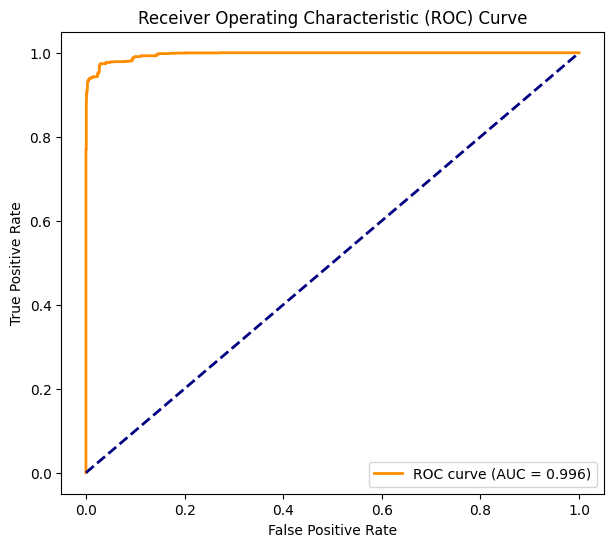

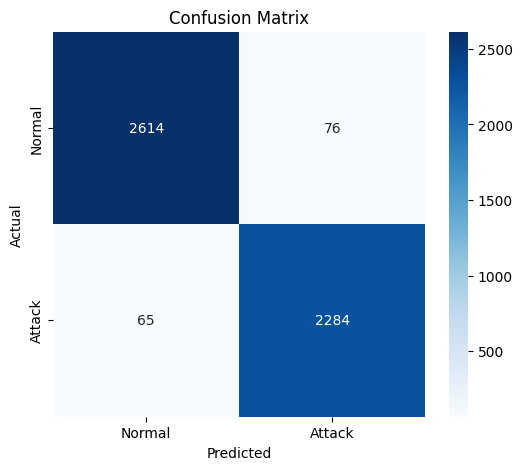

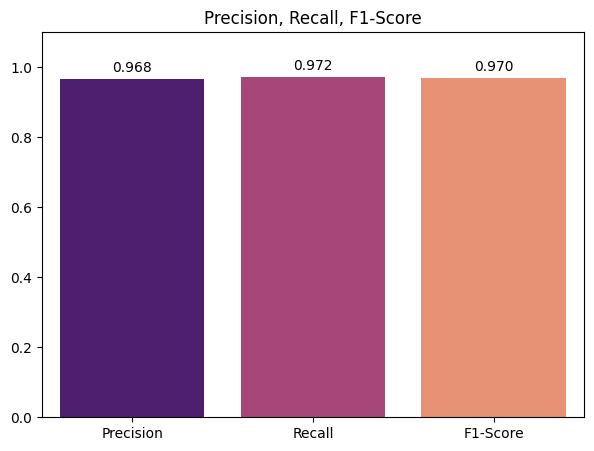

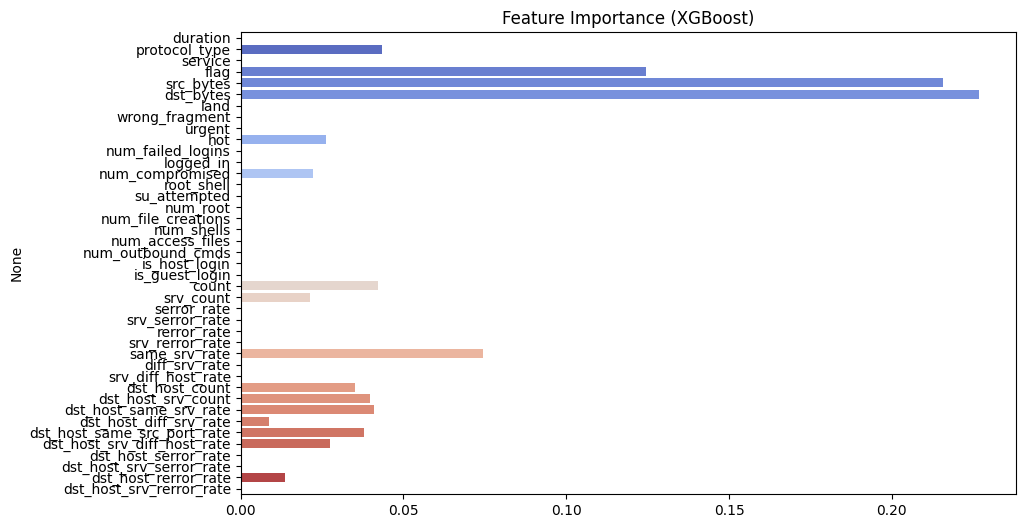

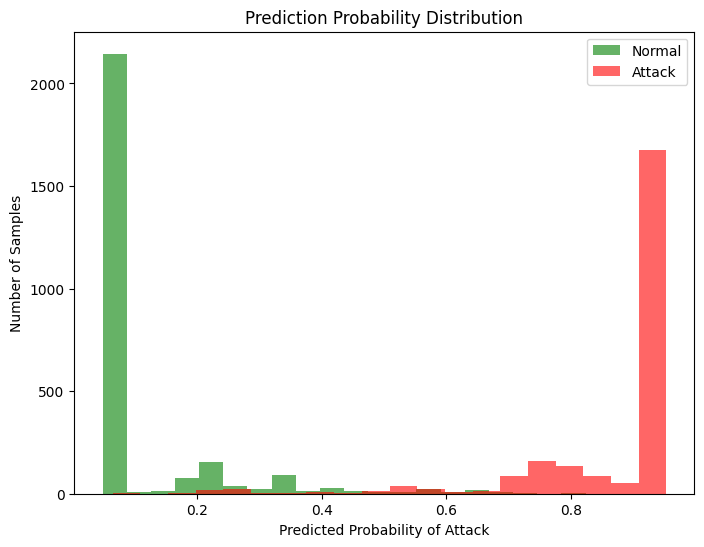

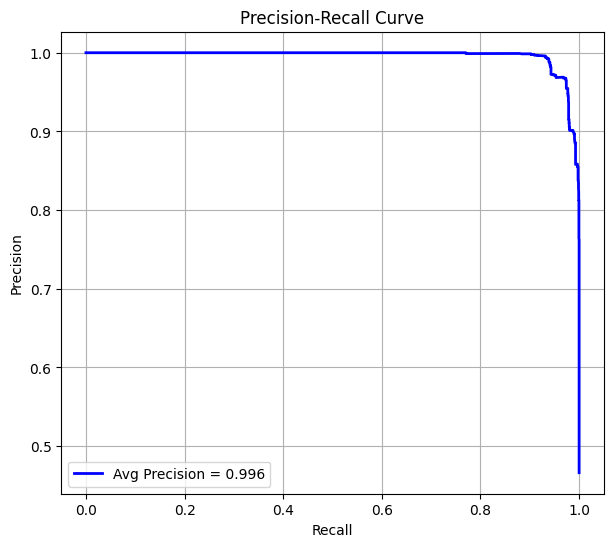

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_score, recall_score, f1_score

# -----------------------------
# 1️⃣ ROC Curve
# -----------------------------
fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# -----------------------------
# 2️⃣ Confusion Matrix
# -----------------------------
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','Attack'], yticklabels=['Normal','Attack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# -----------------------------
# 3️⃣ Precision / Recall / F1-Score Bar Plot
# -----------------------------
metrics = {
    'Precision': precision_score(y_val, y_val_pred),
    'Recall': recall_score(y_val, y_val_pred),
    'F1-Score': f1_score(y_val, y_val_pred)
}

plt.figure(figsize=(7,5))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='magma')
plt.ylim(0,1.1)
plt.title('Precision, Recall, F1-Score')
for i, v in enumerate(metrics.values()):
    plt.text(i, v+0.02, f"{v:.3f}", ha='center')
plt.show()

# -----------------------------
# 4️⃣ Feature Importance
# -----------------------------
importances = model.feature_importances_
features = X_val.columns  # Use validation features for labels
plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=features, palette='coolwarm')
plt.title('Feature Importance (XGBoost)')
plt.show()

# -----------------------------
# 5️⃣ Prediction Probability Distribution
# -----------------------------
plt.figure(figsize=(8,6))
plt.hist(y_val_prob[y_val==0], bins=20, alpha=0.6, label='Normal', color='green')
plt.hist(y_val_prob[y_val==1], bins=20, alpha=0.6, label='Attack', color='red')
plt.xlabel('Predicted Probability of Attack')
plt.ylabel('Number of Samples')
plt.title('Prediction Probability Distribution')
plt.legend()
plt.show()

from sklearn.metrics import precision_recall_curve, average_precision_score

# -----------------------------
# 6️⃣ Precision-Recall Curve
# -----------------------------
precision, recall, thresholds = precision_recall_curve(y_val, y_val_prob)
avg_precision = average_precision_score(y_val, y_val_prob)

plt.figure(figsize=(7,6))
plt.plot(recall, precision, color='b', lw=2, label=f'Avg Precision = {avg_precision:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()



In [44]:
import gradio as gr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
from PIL import Image
import joblib
from sklearn.preprocessing import LabelEncoder

# ===========================
# Load Data and Model
# ===========================
df_original = pd.read_csv("C:/Users/keert/Downloads/data/train_data.csv")
model = joblib.load("xgb_model.pkl")

# Categorical columns
cat_cols = ["protocol_type", "service", "flag"]
encoders = {}
for col in cat_cols:
    enc = LabelEncoder()
    enc.fit(df_original[col])
    encoders[col] = enc

# All features expected by the model
all_features = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
                'land','wrong_fragment','urgent','hot','num_failed_logins','logged_in',
                'num_compromised','root_shell','su_attempted','num_root','num_file_creations',
                'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login',
                'count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate',
                'same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count',
                'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate',
                'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate',
                'dst_host_rerror_rate','dst_host_srv_rerror_rate']

# ===========================
# Confidence Graph (Normal vs Attack)
# ===========================
def plot_confidence_ip(src_ip, dst_ip, prob_attack):
    try:
        prob_attack = float(prob_attack)
        if prob_attack < 0 or prob_attack > 1:
            prob_attack = 0.0
    except:
        prob_attack = 0.0

    fig, ax = plt.subplots(figsize=(6, 3.5), facecolor="#F9FAFB")

    # Labels: Normal / Attack
    labels = ["Normal", "Attack"]
    probs = [1 - prob_attack, prob_attack]
    colors = ["#4CAF50", "#E53935"]

    # Bar chart
    bars = ax.bar(labels, probs, color=colors, width=0.4, edgecolor="#37474F", linewidth=1.3, zorder=3)

    # Titles and axes
    ax.set_ylim(0, 1.05)
    ax.set_ylabel("Confidence", fontsize=12, fontweight="bold", color="#263238", labelpad=10)
    ax.set_title("Network Traffic Confidence", fontsize=14, fontweight="bold", color="#212121", pad=15)

    # Grid and style
    ax.grid(axis='y', linestyle='--', alpha=0.25, zorder=0)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Confidence values above bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2, height + 0.03,
            f"{height:.2f}",
            ha='center', va='bottom',
            fontweight='bold', fontsize=11, color="#000"
        )

    # Axis tick style
    ax.tick_params(axis='x', labelsize=11, colors="#37474F")
    ax.tick_params(axis='y', labelsize=10, colors="#546E7A")

    plt.tight_layout(pad=2)

    # Convert to image
    buf = io.BytesIO()
    plt.savefig(buf, format='png', dpi=150, bbox_inches="tight", facecolor="#F9FAFB")
    buf.seek(0)
    img = np.array(Image.open(buf).convert("RGB"))
    plt.close(fig)
    return img

# ===========================
# Prediction Function
# ===========================
def predict_intrusion(duration, src_bytes, dst_bytes, count, srv_count,
                      protocol_type, service, flag, src_ip, dst_ip):
    
    # Create input dict
    input_dict = {}
    for feat in all_features:
        if feat == "duration":
            input_dict[feat] = [duration]
        elif feat == "src_bytes":
            input_dict[feat] = [src_bytes]
        elif feat == "dst_bytes":
            input_dict[feat] = [dst_bytes]
        elif feat == "count":
            input_dict[feat] = [count]
        elif feat == "srv_count":
            input_dict[feat] = [srv_count]
        elif feat == "protocol_type":
            input_dict[feat] = [protocol_type]
        elif feat == "service":
            input_dict[feat] = [service]
        elif feat == "flag":
            input_dict[feat] = [flag]
        else:
            input_dict[feat] = [df_original[feat].median()]
    
    df_input = pd.DataFrame(input_dict)

    # Encode categorical columns
    for col, enc in encoders.items():
        if df_input[col][0] not in enc.classes_:
            df_input[col][0] = enc.classes_[0]
        df_input[col] = enc.transform(df_input[col])

    # Prediction
    try:
        pred_class = model.predict(df_input)[0]
        pred_prob = model.predict_proba(df_input)[0][1]
    except Exception as e:
        return f"<h2 style='color:red;font-family:Poppins'>❌ Prediction Error: {e}</h2>", None

    # Confidence graph (Normal vs Attack)
    img = plot_confidence_ip(src_ip, dst_ip, pred_prob)

    # Result card styling
    if pred_class == 1:
        bg = "linear-gradient(135deg, #ffebee, #ffcdd2)"
        color = "#C62828"
        border = "2px solid #E53935"
        emoji = "🚨"
        title = "Attack Detected!"
        subtitle = f"Probability: {pred_prob:.2f}"
    else:
        bg = "linear-gradient(135deg, #E8F5E9, #C8E6C9)"
        color = "#2E7D32"
        border = "2px solid #43A047"
        emoji = "✅"
        title = "Normal Traffic"
        subtitle = f"Probability: {1 - pred_prob:.2f}"

    html_output = f"""
    <div style="
        background: {bg};
        border-radius: 18px;
        padding: 25px;
        text-align: center;
        border: {border};
        box-shadow: 0 4px 25px rgba(0,0,0,0.2);
        font-family: 'Poppins', sans-serif;
        color: {color};
        transition: all 0.3s ease;
    ">
        <h2 style="font-size:28px;font-weight:700;margin-bottom:10px;">{emoji} {title}</h2>
        <p style="font-size:18px;font-weight:600;">{subtitle}</p>
        <p style="font-size:14px;color:#555;">Model: <b>XGBoost</b> | Dataset: <b>CTGAN Augmented</b></p>
    </div>
    """
    return html_output, img

# ===========================
# Gradio Interface
# ===========================
iface = gr.Interface(
    fn=predict_intrusion,
    inputs=[
        gr.Number(label="⏱️ Duration (sec)"),
        gr.Number(label="📤 Source Bytes"),
        gr.Number(label="📥 Destination Bytes"),
        gr.Number(label="🔁 Connection Count"),
        gr.Number(label="📊 Service Count"),
        gr.Dropdown(choices=df_original["protocol_type"].unique().tolist(), label="🌐 Protocol Type"),
        gr.Dropdown(choices=df_original["service"].unique().tolist(), label="🧩 Service"),
        gr.Dropdown(choices=df_original["flag"].unique().tolist(), label="🚩 Flag"),
        gr.Textbox(label="Source IP", value="192.168.1.10"),
        gr.Textbox(label="Destination IP", value="10.0.0.5")
    ],
    outputs=[
        gr.HTML(label="Prediction Result"),
        gr.Image(label="📈 Confidence Graph", type="numpy", show_label=True)
    ],
    title="🛡️ AI-Powered Network Intrusion Detection System",
    description=(
        "<div style='text-align:center;font-family:Poppins;font-size:16px;'>"
        "Detect malicious traffic using <b style='color:#6A1B9A;'>CTGAN + XGBoost</b> hybrid model.<br>"
        "Enter flow details below to identify whether the network connection is "
        "<b style='color:#2E7D32;'>Normal</b> or an <b style='color:#C62828;'>Attack</b>."
        "</div>"
    ),
    theme="gradio/soft",
    allow_flagging="never"
)

iface.launch()



C:\Users\keert\AppData\Roaming\Python\Python313\site-packages\gradio\interface.py:415: UserWarning:

The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.



* Running on local URL:  http://127.0.0.1:7875
* To create a public link, set `share=True` in `launch()`.


In [38]:
import joblib

# Load model
model = joblib.load("xgb_model.pkl")

# Check if it's a pipeline with feature names
if hasattr(model, "feature_names_in_"):
    print("Columns expected by the model:")
    print(model.feature_names_in_)
else:
    print("Model does not have feature_names_in_ attribute")


Columns expected by the model:
['duration' 'protocol_type' 'service' 'flag' 'src_bytes' 'dst_bytes'
 'land' 'wrong_fragment' 'urgent' 'hot' 'num_failed_logins' 'logged_in'
 'num_compromised' 'root_shell' 'su_attempted' 'num_root'
 'num_file_creations' 'num_shells' 'num_access_files' 'num_outbound_cmds'
 'is_host_login' 'is_guest_login' 'count' 'srv_count' 'serror_rate'
 'srv_serror_rate' 'rerror_rate' 'srv_rerror_rate' 'same_srv_rate'
 'diff_srv_rate' 'srv_diff_host_rate' 'dst_host_count'
 'dst_host_srv_count' 'dst_host_same_srv_rate' 'dst_host_diff_srv_rate'
 'dst_host_same_src_port_rate' 'dst_host_srv_diff_host_rate'
 'dst_host_serror_rate' 'dst_host_srv_serror_rate' 'dst_host_rerror_rate'
 'dst_host_srv_rerror_rate']
